In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import numpy as np
import random 

import gym
from gym import spaces

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

!pip3 install rlcard

import rlcard
from rlcard.agents import DQNAgent


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Replay buffer
class ReplayBuffer:

    def __init__(self, state_size, pack_size, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.state_size = state_size
        self.pack_size = pack_size
        
        self.buffer_states = np.zeros((buffer_size, state_size*pack_size))
        self.buffer_actions = np.zeros(buffer_size)
        self.buffer_rewards = np.zeros(buffer_size)
        self.buffer_next_states = np.zeros((buffer_size, state_size*pack_size))
        self.buffer_dones = np.zeros(buffer_size)
        #self.buffer = np.zeros((buffer_size, 5))

        self.len = 0

    def append(self,state, action, reward, next_state, done):
        #print(f"""
        #    state: {state}
        #    action: {action}
        #    reward: {reward}
        #    next_state: {next_state}
        #    done: {done}
        #""")
        
        self.buffer_states[self.len] = state
        self.buffer_actions[self.len] = action
        self.buffer_rewards[self.len] = reward
        self.buffer_next_states[self.len] = next_state
        self.buffer_dones[self.len] = done
        
        #self.buffer[self.len] = [state, action, reward, next_state, done]
        self.len += 1
        if self.len >= self.buffer_size:
            self.len = 0
        
    def sample(self):
        experiences = np.random.choice(range(self.len),size=self.batch_size,replace = False)
        states = np.zeros((self.buffer_size, self.state_size*self.pack_size))
        actions = np.zeros(self.batch_size)
        rewards = np.zeros(self.batch_size)
        next_states = np.zeros((self.buffer_size, self.state_size*self.pack_size))
        dones = np.zeros(self.batch_size)
        for i in range(self.batch_size):
            states[i] = self.buffer_states[experiences[i]]
            actions[i] = self.buffer_actions[experiences[i]]
            rewards[i] = self.buffer_rewards[experiences[i]]
            next_states[i] = self.buffer_next_states[experiences[i]]
            dones[i] = self.buffer_dones[experiences[i]]
        return states, actions, rewards, next_states, dones
    

In [3]:

class ActorNetwork(nn.Module):

    def __init__(self, state_size,action_size, lay1_size=128):
        super(ActorNetwork,self).__init__() 
        self.fc1= nn.Linear(state_size,lay1_size)
        self.fc2 = nn.Linear(lay1_size,action_size)
        
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim = 1)

In [4]:
class CriticNetwork(nn.Module):

    def __init__(self, state_size, lay1_size=128):
        super(CriticNetwork,self).__init__() 
        self.fc1= nn.Linear(state_size,lay1_size)
        self.fc2 = nn.Linear(lay1_size,1)
        
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [5]:
class AC_Agent:
    
    def __init__(self, state_size, action_size, gamma, lr, buffer_size, batch_size, pack_size,lay1_size=32):
        #initalize the agent. Since this is a general agent, I won't specify the environment inside the agent.
        #Instead, the informatino will synx from the environment. 
        #save the parameters
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma

        self.batch_size = batch_size
        
        self.pack_size = pack_size
        
        #initalize actor and critic network
        self.actor = ActorNetwork(state_size, action_size, lay1_size).to(DEVICE)
        self.critic = CriticNetwork(state_size, lay1_size).to(DEVICE)     

        #initalize optimizers for the networks
        self.actor_optimizer = optim.SGD(self.actor.parameters(),lr=lr)
        self.critic_optimizer = optim.SGD(self.critic.parameters(),lr=lr)
        
               
        #initalize replay buffer
        self.replay_buffer = ReplayBuffer(state_size, pack_size, action_size, buffer_size, batch_size)
        #initalize step count
        self.step_count = 0
    
    def action(self, state):
      #input: the current state
      #output: the action selected by the actor network and the log probability of the action

      #get the action probability from the actor network
        action_probs = self.actor(torch.from_numpy(state).float().unsqueeze(0).to(DEVICE))
      #categorical the action probability to get the action & calculate the log probabilty
        c = Categorical(action_probs)
        action = c.sample()
        
        return action, c.log_prob(action)
    
                 
    
    def step(self, I, state, action, log, next_state, reward, done):

        self.replay_buffer.append(state, log, reward, next_state, done)

        self.step_count += 1

        if self.replay_buffer.len > self.batch_size:

          states, logs, rewards, next_states, dones = self.replay_buffer.sample()
          #get state value of current state from critic network
                      #----------------
          for state, log, reward, next_state, done in zip(states, logs, rewards, next_states, dones):

            v = self.critic(torch.from_numpy(state).float().unsqueeze(0).to(DEVICE))
                
            if done:
                  #if done, the state value of next state is 0
                    Vp = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)
            else:
                  #otherwise, get the state value for the next state
                    Vp = self.critic(torch.from_numpy(next_state).float().unsqueeze(0).to(DEVICE))

                #calculate the critic loss of the model based on the TD error    
            critic_loss = F.mse_loss(reward + self.gamma * Vp, v)
                
                #calculate the actor loss of the model based on the TD error and log probability 
            actor_loss = -log * (reward + self.gamma * Vp.item() - v.item())
            actor_loss *= I
            actor_loss = torch.tensor([actor_loss],requires_grad=True)
                #update the networks
            self.actor_optimizer.zero_grad()
            actor_loss.backward(retain_graph=True)
            self.actor_optimizer.step()
                
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

              #update I
            I = I * self.gamma
           #----------
        return self, I



        
        


In [13]:
#Agent for env 1 & introduce environment
agent_AC = AC_Agent(state_size = 2, action_size = 2, gamma = 0.99, lr = 0.01, buffer_size=1000, batch_size=5,pack_size = 1)
#agent_AC.shared_memory()
env = rlcard.make("blackjack")

#initalize total rewards
total_rewards = [] 
win=0
#using tqdm to check the learning progress
for i in tqdm(range(10000)):
    #reset environment and parameters
    state,_ = env.reset()
    state = state["obs"]
    I = 1
    final_reward = 0
    
    #maximum 10000 steps
    for t in range(20):
        #pick the action a
        #action, log = agent_AC.action(state)
        #print(t)
        action,log = agent_AC.action(state)
        
        #a execute the action A and ovserve reward r and next state s'
        next_state,_ = env.step(action)
        next_state = next_state["obs"]
        reward = env.get_payoffs()[0]
        #execute the action A and ovserve reward r and next state s'
        if next_state[0] > 21 or action == 1:
            done = 1
        else:
            done = 0


        #update the agent
        agent_AC, I = agent_AC.step(I, state, action,log, next_state, reward, done)

        #update state and total reward
        #print(next_state)
        state = next_state
        final_reward += reward
        
        
        if done:
            if reward == 1: win+=1
            break
    #agent_AC, I = agent_AC.replay_buf_train(I, state, action,log, next_state, reward, done)
    total_rewards.append(final_reward) ## sae the most recent score

        


  0%|          | 0/10000 [00:00<?, ?it/s]

win rate:  0.3799


Text(0.5, 1.0, 'episode vs. total reward')

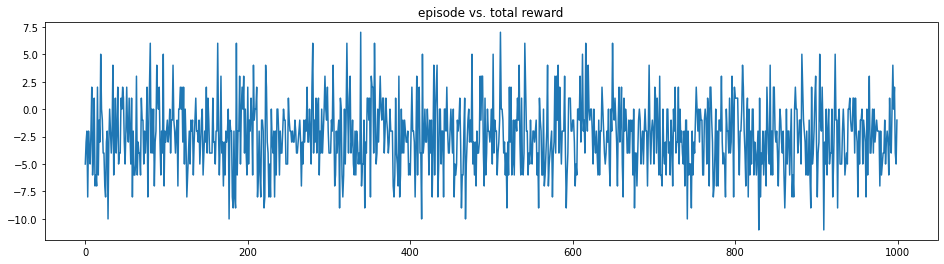

In [15]:
print("win rate: ", win/10000)
tr = []

for i in range(1000):
    r = 0
    for x in range(10):
        r+=total_rewards[i*10+x]
    tr.append(r)

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(range(1000), tr)
plt.title("episode vs. total reward")





In [18]:
#Do the 10 eplision based on greedy actions
#initalize total rewards
total_rewards = [] 
win_rate = 0
win_tie_rate = 0
#using tqdm to check the learning progress
for i in tqdm(range(100)):
    #reset environment and parameters
    state,_ = env.reset()
    state = state["obs"]
    I = 1
    final_reward = 0

    #maximum 10000 steps
    for t in range(20):
        #pick the action a

        action, log = agent_AC.action(state)

        #execute the action A and ovserve reward r and next state s'
        #next_state,reward,done,_ = env.step(action.item())
        next_state,_ = env.step(action)
        next_state = next_state["obs"]
        reward = env.get_payoffs()[0]
        if next_state[0] > 21 or action == 1:
            done = 1
        else:
            done = 0 
        
        #discounted_reward = reward + gamma*discounted_reward
        agent_AC, I = agent_AC.step(I, state, action,log, next_state, reward, done)
        #update the agent
        #agent_AC, I = agent_AC.step(I, state, action,log, next_state, reward, done)

        #update state and total reward
        state = next_state
        final_reward += reward

        if done:
            if reward == 1:     #if the last reward is +1, means agent wins the game
              win_rate += 1
              win_tie_rate += 1 
              
            if reward == 0:     # if the last reward is 0, means tie 
              win_tie_rate += 1

            break

    total_rewards.append(final_reward) ## sae the most recent score

       


  0%|          | 0/100 [00:00<?, ?it/s]

win rate:  0.43
win_tie_rate:  0.48


<Figure size 720x720 with 0 Axes>

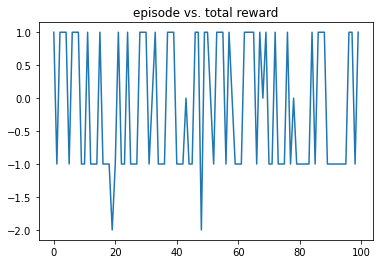

<Figure size 720x720 with 0 Axes>

In [19]:
print("win rate: ", win_rate/100)
print("win_tie_rate: ", win_tie_rate/100)
plt.plot(total_rewards)
plt.title("episode vs. total reward")
plt.figure(2,figsize = (10,10))
